In a data-driven exploration of the socioeconomic factors affecting mental health across the globe, this project taps into extensive data from reputable sources, including Our World in Data and the World Bank's World Development Indicators. The analysis stitches together a comprehensive picture of how Gross Domestic Product (GDP) and compulsory education shape the landscape of mental health disorders, with a spotlight on schizophrenia.

DATA SOURCES:
- Mental Health Data: https://ourworldindata.org/mental-health
- Socioeconomic Indicators: https://databank.worldbank.org/source/world-development-indicators


In [19]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import nbformat
import os
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objs as go
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import ttest_ind
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from yellowbrick.model_selection import FeatureImportances
import warnings

# Set display options to utilize the full width of the editor
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Do not wrap the frame to fit the display
pd.set_option('display.width', None)  # Use the full display width

pwd =os.getcwd()

In [20]:
data = pd.read_csv(pwd + "\\Data\\Wip\\Mental_Health_Final.csv")

- Country: Country name.
- Code: Country code.
- Year: The year of the data record.
- Schizophrenia: Prevalence of schizophrenia (presumably in %).
- Bipolar disorder: Prevalence of bipolar disorder (in %).
- Eating disorders: Prevalence of eating disorders (in %).
-  Anxiety disorders: Prevalence of anxiety disorders (in %).
- Depressive disorders: Prevalence of depressive disorders (in %).
- Drug use disorders: Prevalence of drug use disorders (in %).
- Alcohol use disorders: Prevalence of alcohol use disorders (in %).
- Population: Population of the country in that year.
- GDP: Gross Domestic Product of the country in that year.
- Compulsory education: Duration of compulsory education in years.

# Data Exploration and Understanding

In [21]:
data_info = data.info()
data_description = data.describe()

# Check for missing values
missing_values = data.isnull().sum()

data_info, data_description, missing_values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4137 entries, 0 to 4136
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Country                4137 non-null   object 
 1   Code                   4137 non-null   object 
 2   Year                   4137 non-null   int64  
 3   Schizophrenia          4137 non-null   float64
 4   Bipolar disorder       4137 non-null   float64
 5   Eating disorders       4137 non-null   float64
 6   Anxiety disorders      4137 non-null   float64
 7   Depressive disorders   4137 non-null   float64
 8   Drug use disorders     4137 non-null   float64
 9   Alcohol use disorders  4137 non-null   float64
 10  Population             4137 non-null   int64  
 11  GDP                    4137 non-null   float64
 12  Compulsory education   4137 non-null   int64  
dtypes: float64(8), int64(3), object(2)
memory usage: 420.3+ KB


(None,
               Year  Schizophrenia  Bipolar disorder  Eating disorders  Anxiety disorders  Depressive disorders  Drug use disorders  Alcohol use disorders    Population           GDP  Compulsory education
 count  4137.000000    4137.000000       4137.000000       4137.000000        4137.000000           4137.000000         4137.000000            4137.000000  4.137000e+03  4.137000e+03           4137.000000
 mean   2009.000000       0.279374          0.688666          0.216398           4.339229              3.955294            0.720703               1.569688  3.462392e+07  3.064437e+11              8.686488
 std       6.056033       0.046996          0.250845          0.161132           1.222364              0.960745            0.427104               0.934486  1.337541e+08  1.332096e+12              3.150879
 min    1999.000000       0.190000          0.190000          0.050000           1.970000              1.640000            0.240000               0.320000  9.344000e+03  1.3

# Data Preparation

In [22]:
# Convert GDP to billions
data['GDP'] = (data['GDP'] / 1e9).round(2)

# Convert Year to Date Format (January 1st of each year)
data['Year'] = pd.to_datetime(data['Year'], format='%Y').dt.date

# Print the first few rows to check the changes
print(data.head())

       Country Code        Year  Schizophrenia  Bipolar disorder  Eating disorders  Anxiety disorders  Depressive disorders  Drug use disorders  Alcohol use disorders  Population   GDP  Compulsory education
0  Afghanistan  AFG  1999-01-01           0.22              0.72               0.1               4.78                  5.12                0.42                   0.44    20170847  1.10                     6
1  Afghanistan  AFG  2000-01-01           0.22              0.72               0.1               4.79                  5.12                0.42                   0.44    20779957  1.10                     6
2  Afghanistan  AFG  2001-01-01           0.22              0.72               0.1               4.79                  5.12                0.43                   0.44    21606992  2.21                     6
3  Afghanistan  AFG  2002-01-01           0.22              0.72               0.1               4.79                  5.12                0.44                   0.44    22

# Analysis and Insights

### Average prevalence of each mental health disorder

We'll calculate the average prevalence rates for each mental health disorder in the dataset and then visualize these averages to compare across disorders effectively. This approach will provide a clear picture of how different mental health disorders compare in terms of their average prevalence.

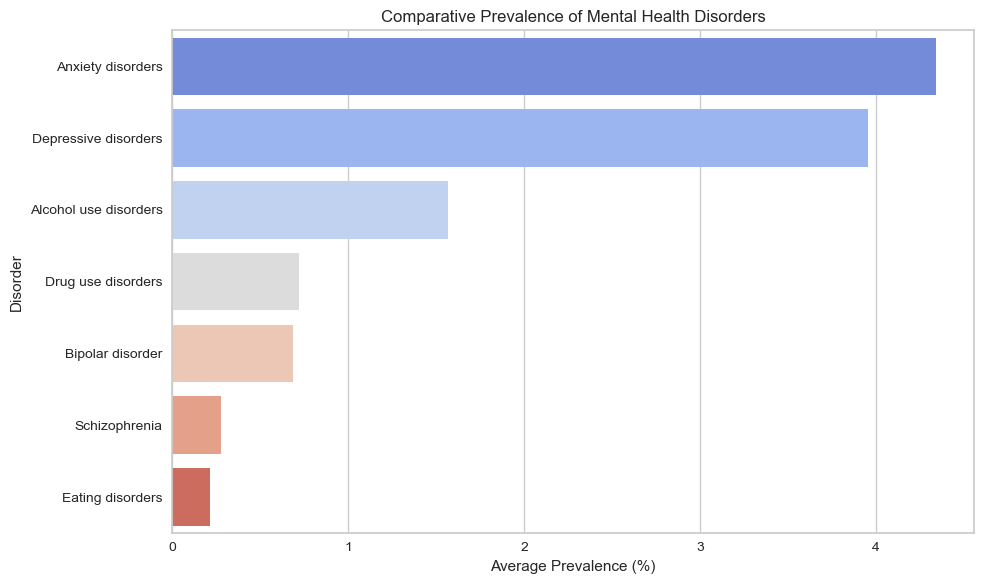

In [38]:
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

# Calculate the average prevalence of each mental health disorder in the dataset
average_prevalence = data[['Schizophrenia', 'Bipolar disorder', 'Eating disorders', 
                           'Anxiety disorders', 'Depressive disorders', 'Drug use disorders', 
                           'Alcohol use disorders']].mean().sort_values(ascending=False)

# For visualization, converting the series to a dataframe for easier plotting
average_prevalence_df = average_prevalence.reset_index()
average_prevalence_df.columns = ['Disorder', 'Average Prevalence']

plt.figure(figsize=(10, 6))
sns.barplot(x='Average Prevalence', y='Disorder', hue='Disorder', data=average_prevalence_df, palette='coolwarm', legend=False)
plt.title('Comparative Prevalence of Mental Health Disorders')
plt.xlabel('Average Prevalence (%)')
plt.ylabel('Disorder')
plt.tight_layout()

- Anxiety Disorders have the highest average prevalence among the disorders listed, indicating that they are the most common mental health issue in the dataset. This reflects global trends where anxiety disorders are widely recognized as one of the most prevalent mental health conditions.
- Depressive Disorders follow closely, underscoring the significant impact of depression on populations worldwide. The close prevalence rates of anxiety and depressive disorders highlight the widespread nature of mood-related mental health issues.
- Drug Use Disorders and Alcohol Use Disorders show lower average prevalence rates compared to mood disorders (anxiety and depressive disorders). However, their impact is still notable, suggesting a significant public health concern regarding substance use and its mental health implications.
- Schizophrenia, Bipolar Disorder, and Eating Disorders have the lowest average prevalence rates in the dataset. These conditions, while less prevalent on average, represent complex challenges for mental health services due to their severe impact on individuals' lives and the need for specialized treatment.


### Comparative Prevalence of Mental Health Disorders by Country

In [43]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    
    fig = px.bar(melted_data, y='Country', x='Prevalence', color='Disorder',
                 title='Comparative Prevalence of Mental Health Disorders by Country',
                 labels={'Prevalence': 'Mean Prevalence (%)'},
                 orientation='h',  # This ensures the bars are horizontal
                 height=1500  # Adjust the height based on the number of countries
                )
    fig.show()

### Comparative Prevalence of Mental Health Disorders

The boxplot visualization provides a succinct comparison of the prevalence of various mental health disorders, revealing key insights into their distribution, median rates, variability, and outliers across countries. This analysis allows for the identification of disorders with higher or more variable prevalence rates, guiding further investigation and informing public health priorities and interventions.

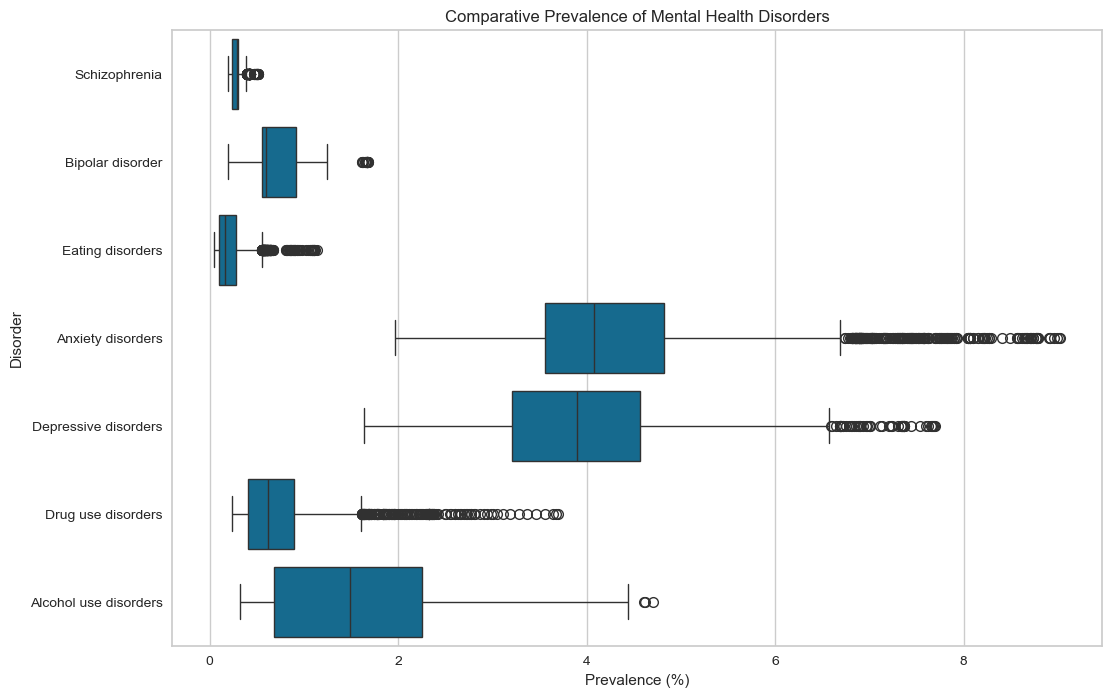

In [25]:
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
# Melting the dataset for boxplot comparison
melted_data = pd.melt(data, id_vars=['Country', 'Year', 'Population', 'GDP', 'Compulsory education'], 
                      value_vars=['Schizophrenia', 'Bipolar disorder', 'Eating disorders', 
                                  'Anxiety disorders', 'Depressive disorders', 'Drug use disorders', 
                                  'Alcohol use disorders'],
                      var_name='Disorder', value_name='Prevalence')

plt.figure(figsize=(12, 8))
sns.boxplot(x='Prevalence', y='Disorder', data=melted_data)
plt.title('Comparative Prevalence of Mental Health Disorders')
plt.xlabel('Prevalence (%)')
plt.ylabel('Disorder')
plt.show()

- Anxiety Disorders: The box for anxiety disorders is positioned higher on the prevalence scale, indicating a higher median prevalence compared to other disorders. The interquartile range (IQR) is relatively small, suggesting that the prevalence rates are more consistent across the dataset.
- Depressive Disorders: The median prevalence of depressive disorders is slightly lower than that of anxiety disorders, with a larger IQR. This indicates more variability in the prevalence of depressive disorders across the dataset.
- Alcohol Use Disorders: This category has a wide IQR, showing significant variability in the prevalence among different countries or over time. The median is lower than for anxiety and depressive disorders, but the spread of data points suggests diverse rates of alcohol use disorders.
- Drug Use Disorders: The prevalence of drug use disorders appears to be lower and less variable than alcohol use disorders, indicated by a smaller IQR.
- Bipolar Disorder: The boxplot shows that bipolar disorder has a lower median prevalence than the mood disorders and substance use disorders above it. The IQR is relatively tight, suggesting less variability in prevalence.
- Schizophrenia and Eating Disorders: Both disorders have the lowest median prevalence rates and appear to have outliers indicating that there are countries or years where the prevalence rates are significantly different from the general trend.

Mood Disorders: The mood disorders, including anxiety and depressive disorders, are more prevalent than other types of disorders in the dataset, which is consistent with global health data that typically show higher prevalence rates for these conditions.

Substance Use: The wide range for alcohol use disorders suggests that cultural, legal, and socioeconomic factors might be influencing its prevalence to a greater extent than the other disorders represented here.

Consistency vs. Variability: Disorders with tighter IQRs (like bipolar disorder) suggest more consistency in their prevalence rates, while those with wider IQRs (like alcohol use disorders) suggest more variability either across countries or over time.


### Correlation between GDP, Compulsory Education, and Mental Health Disorders

In [26]:

# Select columns for correlation
selected_columns = ['GDP', 'Compulsory education', 'Schizophrenia', 'Bipolar disorder', 'Eating disorders', 'Anxiety disorders', 'Depressive disorders', 'Drug use disorders', 'Alcohol use disorders']

# Calculate the correlation matrix for the selected columns
correlation_matrix = data[selected_columns].corr()

# Extract the correlation values between 'Compulsory education' and 'GDP' with each 'Disorder'
subset_correlation = correlation_matrix[['Compulsory education', 'GDP']][2:]

# Create a heatmap of the subset correlation matrix
fig = go.Figure(data=go.Heatmap(z=subset_correlation.values,
                                x=subset_correlation.columns,
                                y=subset_correlation.index,
                                colorscale='Viridis'))

# Add text annotations with the correlation values
annotations = []
for i in range(len(subset_correlation.index)):
    for j in range(len(subset_correlation.columns)):
        annotations.append(
            dict(
                x=subset_correlation.columns[j],
                y=subset_correlation.index[i],
                text="{:.2f}".format(subset_correlation.values[i, j]),
                showarrow=False,
                font=dict(size=10),
            )
        )

fig.update_layout(
    title='Correlation between GDP, Compulsory Education, and Mental Health Disorders',
    xaxis=dict(title='Variables'),
    yaxis=dict(title='Disorders'),
    annotations=annotations  # Add the annotations
)

fig.show()

- Education: The overall positive correlation between mental health disorders and compulsory education across most disorders might reflect increased detection and reporting in countries with more extensive education systems. Longer education could lead to greater awareness and thus higher reporting rates.
- GDP: The varying correlation with GDP across different disorders suggests that economic wealth might influence the prevalence or reporting of certain disorders (like drug use disorders) more than others.


### Cluster Analysis



This  can reveal patterns and similarities among countries, offering valuable insights into how different factors correlate with mental health outcomes. For example, clusters may differentiate countries with high GDP and education levels from those with lower values and varying prevalence of mental health disorders, highlighting potential socioeconomic determinants of mental health.

In [27]:
# Select features for clustering (e.g., GDP, Compulsory education, and all disorder prevalences)
features = ['GDP', 'Compulsory education', 'Schizophrenia', 'Bipolar disorder', 'Eating disorders', 'Anxiety disorders', 'Depressive disorders', 'Drug use disorders', 'Alcohol use disorders']

# Standardize the features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[features])

# Apply K-Means clustering to group countries based on similar characteristics
kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(data_scaled)

# Explore the resulting clusters
cluster_summary = data.groupby('Cluster')[features].mean()
print(cluster_summary)

                GDP  Compulsory education  Schizophrenia  Bipolar disorder  Eating disorders  Anxiety disorders  Depressive disorders  Drug use disorders  Alcohol use disorders
Cluster                                                                                                                                                                         
0         51.920006              6.960576       0.236915          0.615426          0.133398           4.028986              4.642972            0.428154               0.963148
1        247.729028              9.353333       0.297739          0.621472          0.177611           3.881944              3.268489            0.744550               1.768678
2        999.833965             10.794317       0.326455          1.010704          0.490352           6.123911              4.141137            1.295223               2.396576


- Cluster 0: This cluster has the lowest GDP and compulsory education duration compared to the other clusters. It also has lower average prevalence rates for mental health disorders across the board, except for depressive disorders, which are higher than in Cluster 1. This cluster might represent lower-income countries with less education and lower reported rates of mental health disorders, which could be due to less mental health awareness or underdiagnosis.

- Cluster 1: This cluster has a higher GDP than Cluster 0 and a longer duration of compulsory education. The prevalence rates of mental health disorders are generally higher than in Cluster 0, except for depressive disorders, which are notably lower. The higher prevalence of drug use disorders and alcohol use disorders could suggest that countries in this cluster are more developed, with better detection and reporting systems, or potentially greater substance use problems.

- Cluster 2: The countries in this cluster have the highest GDP and the longest compulsory education duration. They also have the highest prevalence rates for all mental health disorders, particularly bipolar disorder, eating disorders, anxiety disorders, and substance use disorders. This cluster likely represents the most developed countries with the most extensive mental health reporting and possibly greater awareness of mental health issues.

Socioeconomic Status and Mental Health Reporting: There seems to be a correlation between a country's socioeconomic status (as indicated by GDP and education levels) and the reported prevalence rates of mental health disorders. Higher socioeconomic status could be associated with better health care and more thorough reporting, which may explain the higher prevalence rates.

Economic Development and Substance Use: The clusters suggest that as GDP increases, so does the prevalence of substance use disorders. This could be reflective of increased availability, cultural acceptance, or the stresses associated with more industrialized and urbanized societies.
Mental Health and Education: Longer compulsory education is associated with higher reported rates of mental health disorders. This could be due to better education leading to greater awareness and less stigma, resulting in higher reporting rates.


# A closer look at Schizophrenia

### Schizophrenia Geospatial Analysis



- The color gradient represents the prevalence rate of schizophrenia, with different shades indicating varying rates from lower (purple) to higher (yellow).
- The majority of the countries are colored in shades of yellow, indicating a general mid-to-high prevalence rate of schizophrenia.
- Some countries, possibly those with lower data availability or reporting, are colored purple, indicating a lower prevalence rate.
- There are noticeable variations across different regions, which could be attributed to genetic, environmental, socio-economic factors, or differences in diagnostic practices and healthcare reporting.

In [45]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    
    fig = px.choropleth(data, locations='Country', locationmode='country names', color='Schizophrenia',
                        hover_name='Country', animation_frame='Year',
                        title='Schizophrenia Prevalence Across Countries Over Time',
                        color_continuous_scale=px.colors.sequential.Plasma)
    fig.show()


- Data Interpretation: When interpreting this map, it's crucial to consider the quality of the data sources. Prevalence rates can be affected by the availability and accuracy of healthcare reporting systems in each country.
- Healthcare Accessibility: Countries with more developed healthcare systems might report higher prevalence rates due to better detection and diagnosis.
- Cultural Factors: Cultural differences in the recognition and reporting of mental health symptoms can also affect the perceived prevalence of schizophrenia.
- Genetic and Environmental Influences: Genetic predisposition to schizophrenia, as well as environmental factors like urbanicity, stress, and substance use, could explain some of the geographical patterns observed.


### Time Series Analysis

Each line corresponds to a different country within the dataset.

In [29]:
# Select a specific disorder (e.g., Schizophrenia) for time series analysis
disorder = 'Schizophrenia'

# Create a line chart for the trend of the selected disorder over the years
fig = px.line(data, x='Year', y=disorder, title=f'Trend of {disorder} Over the Years')
fig.show()

- Prevalence Rates: The prevalence rates of schizophrenia appear to be spread between approximately 0.2% and 0.5%. This spread indicates the variance in schizophrenia prevalence among different populations or data subsets over time.
- Stability Over Time: There is no clear upward or downward trend visible in the prevalence rates; the lines are relatively stable across the years. This suggests that the prevalence of schizophrenia has not changed significantly during the period covered by the data.
- Data Density: There is a dense clustering of lines at the lower end of the prevalence scale, which may indicate that a majority of the data points or countries have lower prevalence rates.


### Regression Analysis

Quantify the relationship between a specific disorder (e.g., Schizophrenia) and predictor variables (e.g., GDP, Compulsory education)

In [30]:
# Select a specific disorder (e.g., Schizophrenia) for regression analysis
disorder = 'Schizophrenia'

# Fit a linear regression model to explore the relationship with GDP and Compulsory education
X = data[['GDP', 'Compulsory education']]
X = sm.add_constant(X)  # Add a constant term
y = data[disorder]

model = sm.OLS(y, X).fit()

# Display regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Schizophrenia   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     520.3
Date:                Thu, 01 Feb 2024   Prob (F-statistic):          2.84e-202
Time:                        22:23:58   Log-Likelihood:                 7244.5
No. Observations:                4137   AIC:                        -1.448e+04
Df Residuals:                    4134   BIC:                        -1.446e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.2413 

- Dependent Variable: The dependent variable is the prevalence of schizophrenia.
- R-squared: The R-squared value is 0.201, meaning that approximately 20.1% of the variability in schizophrenia prevalence can be explained by the model. This is a moderate level of explanatory power, suggesting that while GDP and compulsory education have some relationship with schizophrenia prevalence, there are likely other significant factors not captured by the model.
- F-statistic: The F-statistic is significant (Prob(F-statistic) < 0.05), indicating that the model is statistically significant and that the independent variables collectively have a statistically significant effect on schizophrenia prevalence.
- Coefficients:
- The constant term is 0.2413, which could be interpreted as the baseline prevalence of schizophrenia when GDP and compulsory education are zero (which is not practical but is a requirement of the regression equation).
- The GDP coefficient is 1.152e-05 (or 0.00001152), which means that for each unit increase in GDP (which should be in billions as per your previous transformation), the prevalence of schizophrenia increases by an average of 0.00001152 units.
- The coefficient for compulsory education is 0.004, suggesting that for each additional year of compulsory education, the prevalence of schizophrenia increases by 0.004 units on average.
- P-values:
- All variables, including GDP and compulsory education, have p-values significantly less than 0.05, indicating that these variables are statistically significant predictors of schizophrenia prevalence in this model.
- Confidence Intervals:
- The 95% confidence intervals for GDP and compulsory education do not contain zero, further confirming the statistical significance of these predictors.

The positive coefficient for GDP suggests that higher economic status (as measured by GDP) is associated with a higher reported prevalence of schizophrenia. This could be due to better detection and diagnosis in wealthier countries, rather than an actual increase in the disorder's occurrence.

The positive coefficient for compulsory education suggests that with more years of compulsory education, the prevalence of schizophrenia is also higher. This could be due to better awareness and thus reporting of mental health issues in countries with longer education.

The model's R-squared indicates that while GDP and compulsory education are related to schizophrenia prevalence, they do not explain most of the variability. There are likely other important factors not included in the model.


### Outlier Detection


Identify and analyze outliers in the dataset, especially in variables like GDP or disorder prevalence. Investigate if these outliers are meaningful or require special attention.

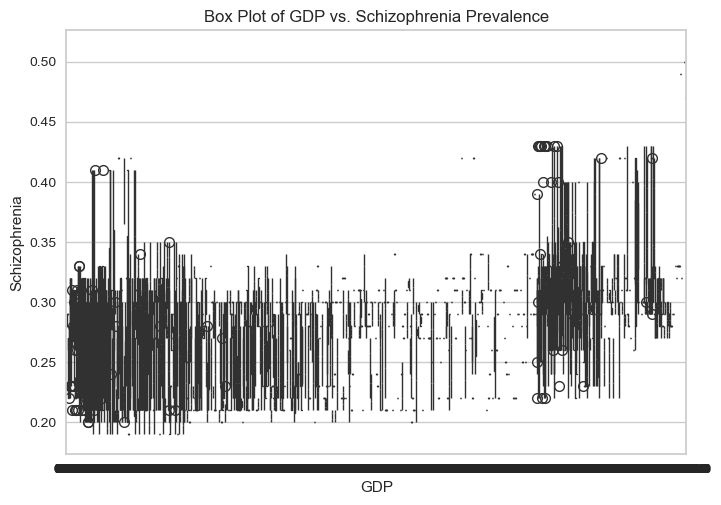

In [46]:
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
# Visualize potential outliers in GDP and selected disorder (e.g., Schizophrenia)
sns.boxplot(x='GDP', y='Schizophrenia', data=data)
plt.title('Box Plot of GDP vs. Schizophrenia Prevalence')
plt.show()


- Wide Range of GDP: The box plot shows a wide range of GDP values. Since GDP is on the x-axis and there's no clear segmentation into categories, it makes the interpretation a bit challenging. Typically, a box plot is used to display the distribution of a variable and identify outliers within categorical groups.

- Schizophrenia Prevalence: The prevalence of schizophrenia, which is spread along the y-axis, has a concentration of values between approximately 0.25% and 0.45%. The median value seems to be around 0.35%, which is where the central line in the box would be.

- Outliers: There are numerous data points above the upper whisker and beyond the main cluster of the data, which could be considered outliers in terms of schizophrenia prevalence. These could represent countries or regions with particularly high reported rates of schizophrenia.


Data Spread: The spread of schizophrenia prevalence does not seem to show a distinct pattern as GDP increases. This suggests that GDP alone does not have a straightforward relationship with schizophrenia prevalence rates.

Potential Outliers: The outliers might indicate that for some countries, the prevalence of schizophrenia is reported at much higher rates, which could be due to actual higher rates of the disorder, better detection and reporting, or differences in diagnostic criteria.


### Time Lag Analysis 

- Time lag analysis explores potential delayed effects between GDP and the selected disorder (e.g., Schizophrenia).
- Calculate correlations at different time lags to identify if changes in GDP precede or follow changes in the disorder prevalence.
- Interpretation involves assessing the strength and direction of correlations at different time lags.

In [32]:
## Select a specific disorder (e.g., Schizophrenia) for time lag analysis
disorder = 'Schizophrenia'

# Calculate time lag correlations between GDP and the selected disorder
lags = range(1, 6)  # Define the time lags to explore (e.g., 1 to 5 years)
correlation_results = []

for lag in lags:
    data['GDP_Lagged'] = data.groupby('Country')['GDP'].shift(lag)
    correlation = data[['GDP_Lagged', disorder]].corr().iloc[0, 1]
    correlation_results.append(correlation)

lag_correlations = pd.DataFrame({'Time_Lag': lags, 'Correlation': correlation_results})
print(lag_correlations)

   Time_Lag  Correlation
0         1     0.364223
1         2     0.365861
2         3     0.366827
3         4     0.367231
4         5     0.367637


- The correlation coefficients between GDP and the prevalence of schizophrenia for time lags of 1 to 5 years range from 0.364 to 0.368.
- These results indicate a consistently moderate positive correlation across all examined time lags, suggesting that higher GDP is associated with higher reported prevalence rates of schizophrenia.
- The slight increase in the correlation coefficient as the time lag increases could suggest that the impact of GDP on schizophrenia prevalence may have a delayed effect, or it may take time for changes in GDP to reflect in the prevalence rates due to factors like healthcare system responsiveness and changes in public health policy.


### Hypothesis Testing

Interpretation:
- Interpretation involves assessing the p-value and deciding if the difference is statistically significant.

In [33]:
# Perform a t-test to compare Schizophrenia prevalence between countries with and without compulsory education
group1 = data[data['Compulsory education'] > 0]['Schizophrenia']
group2 = data[data['Compulsory education'] == 0]['Schizophrenia']

t_stat, p_value = ttest_ind(group1, group2, equal_var=False)

# Display test results
print(f'T-Statistic: {t_stat}')
print(f'P-Value: {p_value}')

T-Statistic: 5.326033664601981
P-Value: 1.9481153930493393e-07


- T-Statistic (5.326): The t-statistic is a measure of the difference between the two groups in terms of the number of standard errors. A t-statistic of 5.326 is quite high, which indicates a substantial difference between the average prevalence of schizophrenia in countries with compulsory education compared to those without.
- P-Value (approximately 0.0000001948): The p-value tells us the probability of observing the data—or something more extreme—if the null hypothesis is true. The null hypothesis in this case would be that there is no difference in schizophrenia prevalence between countries with and without compulsory education. A p-value this low (far below the standard alpha level of 0.05) allows us to reject the null hypothesis, indicating that the difference observed is statistically significant.


Statistical Significance: The results suggest that there is a statistically significant difference in the prevalence of schizophrenia between countries with compulsory education and those without.

Implications: This could imply that education has an impact on the detection and reporting of schizophrenia. It could also be a proxy for other factors, such as the overall development level of a country, healthcare infrastructure, or cultural attitudes towards mental health.


### Machine Learning Model

Interpretation:
- Interpretation involves assessing the model's performance using metrics like Mean Squared Error (MSE) to understand how well it predicts the prevalence of the selected disorder.

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Select a specific disorder (e.g., Schizophrenia) for modeling
disorder = 'Schizophrenia'

# Split the data into training and testing sets
X = data[['GDP', 'Compulsory education']]
y = data[disorder]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 0.0018144682502373502


- Mean Squared Error (MSE): The MSE of 0.0018144682502373502 is the average squared difference between the observed actual outturns and the predictions by the model. Since MSE is scale-dependent (meaning its value is based on the scale of the data), without additional context, such as the variance of schizophrenia prevalence in the dataset, it's difficult to judge the absolute performance of the model. However, the lower the MSE, the better the model has performed in terms of prediction accuracy.

### Model Validation

Interpretation:

- The Mean Squared Error (MSE) scores provide an estimate of the model's prediction error.
- Interpret the results by considering the mean MSE and standard deviation of MSE scores. Lower MSE indicates better model performance, and a lower standard deviation suggests more stable results.

In [35]:
# Select a specific disorder (e.g., Schizophrenia)
disorder = 'Schizophrenia'

# Prepare the data
X = data[['GDP', 'Compulsory education']]
y = data[disorder]

# Create a linear regression model
model = LinearRegression()

# Perform cross-validation to evaluate model performance
scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5)
mse_scores = -scores  # Convert negative MSE scores to positive

# Calculate the mean and standard deviation of MSE scores
mean_mse = mse_scores.mean()
std_mse = mse_scores.std()

print(f'Mean MSE: {mean_mse}')
print(f'Standard Deviation of MSE: {std_mse}')

Mean MSE: 0.0018378363100475983
Standard Deviation of MSE: 0.0003607255332453496


- Mean MSE (0.0018378363100475983): This is the average of the MSE scores across the 5 folds of cross-validation. It represents the average squared difference between the observed actual outcomes and the outcomes predicted by the model. A lower MSE indicates a better fit of the model to the data. In the context of your model, this value suggests that, on average, the model's predictions are reasonably close to the actual data points.
- Standard Deviation of MSE (0.0003607255332453496): This value measures the variability of the MSE scores across the 5 folds. A lower standard deviation indicates that the model's performance is consistent across different subsets of the data. The relatively low standard deviation in your results suggests that the model's performance is quite stable across the folds of the cross-validation process.


- Model Performance: The model seems to predict the prevalence of schizophrenia with a consistent level of accuracy across different data samples, as indicated by the low standard deviation in MSE.
- Model Reliability: The consistency of the model, as evidenced by the low standard deviation, implies that the model's performance is reliable and not highly dependent on the particular sample of data it's trained on.
- Generalizability: Given that cross-validation is designed to test the model's ability to perform well on unseen data, these results suggest that your model may generalize well when applied to new data, within the scope of the data it was trained on.


### Feature Importance Analysis

Interpretation:
- The importance scores indicate the relative contribution of each feature to the model's predictions.
- Interpret the results by noting which variable has a higher importance score. A higher score suggests that the variable is more influential in predicting Schizophrenia prevalence.

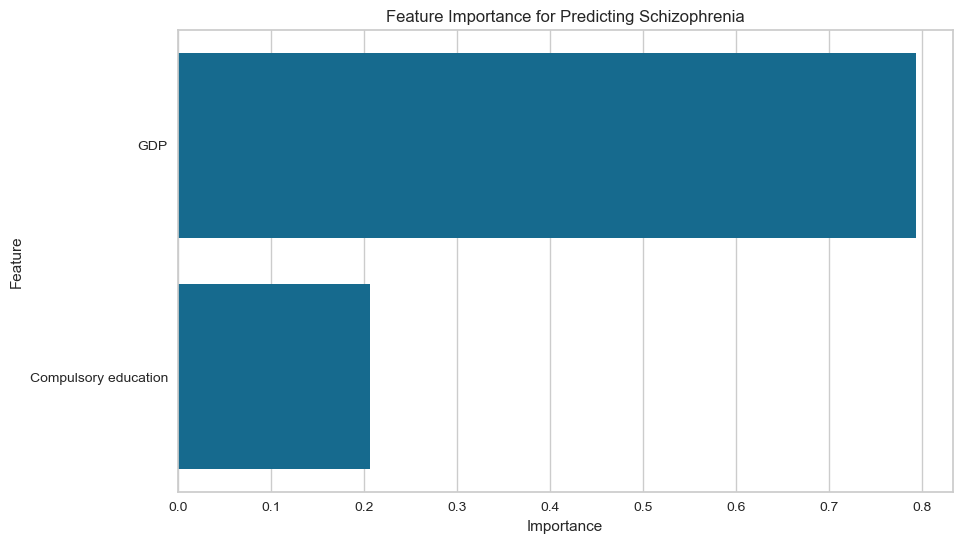

In [36]:
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
# Select a specific disorder (e.g., Schizophrenia)
disorder = 'Schizophrenia'

# Prepare the data
X = data[['GDP', 'Compulsory education']]
y = data[disorder]

# Fit a Random Forest Regressor model to assess feature importance
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
# Create a bar chart to visualize feature importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, orient='h')
plt.title(f'Feature Importance for Predicting {disorder}')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

- GDP: GDP appears to have a significantly higher importance score in predicting schizophrenia prevalence compared to compulsory education. This suggests that, according to the model, GDP is a more influential predictor when estimating the prevalence of schizophrenia. The economic status of a country, as represented by GDP, could be related to various factors influencing mental health prevalence, such as healthcare quality, access to mental health services, or overall life conditions.
- Compulsory Education: Although compulsory education has a lower importance score, it is still a relevant feature in the model. The duration of education may reflect broader social and development indicators that could influence mental health outcomes, including awareness, stigma, and early intervention.

- Economic Influence: The model suggests that economic factors may be more closely tied to the prevalence of schizophrenia than education factors. This could be reflective of the broader impacts of economic conditions on public health.
- Policy Implications: For policymakers and health professionals, the insight that GDP is a significant predictor of schizophrenia prevalence could inform targeted interventions and resource allocation. It may indicate that economic development and stability could have broader benefits for public mental health.
- Social Determinants of Health: The importance of GDP in the model underscores the role of social determinants of health. It may imply that policies aimed at economic improvement could also positively impact mental health outcomes.


# Conclusion

### Key Findings:
- GDP appears to be a consistent predictor of mental health disorder prevalence, potentially due to better healthcare infrastructure and reporting in higher GDP countries.
- Compulsory education's impact is less pronounced but still relevant, which might reflect broader social influences on mental health outcomes.
- Stable prevalence rates over time suggest that schizophrenia rates do not fluctuate dramatically year-on-year within the same countries.

The analysis has provided valuable insights into the relationship between socioeconomic factors and the prevalence of mental health disorders. It underscores the importance of considering a wide range of influences, from economic conditions to educational structures, in understanding and addressing mental health at a population level. While GDP and compulsory education are significant factors, mental health is a multi-faceted issue that requires a holistic approach for effective management and intervention.

The findings can be used to inform policymakers, healthcare providers, and researchers interested in the socio-economic determinants of mental health. Further research could expand on these findings, exploring additional data and employing more sophisticated modeling techniques to deepen our understanding of these complex relationships.
